In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Dataset/AU-PEMal-2025-V2.csv')

In [4]:
df.head()

,sha1,processes_malicious,processes_monitored,processes_suspicious,total_procsses,files_malicious,files_suspicious,files_unknown,files_text,registry_total,...,text_PointerToRawData,BaseOfCode,BaseOfData,ImageBase,Checksum,SectionAlignment,SizeOfHeaders,Class,Category,Family
0,62f4d55a1bb8396e493d7815dc44febed7161535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1024,4096,16384,5368709120,125136,4096,1024,Benign,Benign,Benign
1,ca40945a4e35d48794a5e13aacf16b8ae1caddeb,0.0,2.0,0.0,93.0,0.0,0.0,0.0,0.0,5.0,...,1024,4096,16384,5368709120,5202495,4096,1024,Benign,Benign,Benign
2,6f47b50480bea61ae4dfb75c12582990cc5ce770,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,58.0,...,512,8192,16384,4194304,0,8192,512,Benign,Benign,Benign
3,8c3d5b506a8d55f42f4c83ead3e4341255d1acfc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1536,4096,16384,4194304,0,4096,1536,Benign,Benign,Benign
4,0a7d0c68c591db2f197b2169d226bebe6e9bdabe,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,253.0,...,512,8192,0,4194304,0,8192,512,Benign,Benign,Benign


In [5]:
df['Class'].unique()

array(['Benign', 'Malware'], dtype=object)

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.shape

(21703, 39)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21703 entries, 0 to 21702
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sha1                     21703 non-null  object 
 1   processes_malicious      21703 non-null  float64
 2   processes_monitored      21703 non-null  float64
 3   processes_suspicious     21703 non-null  float64
 4   total_procsses           21703 non-null  float64
 5   files_malicious          21703 non-null  float64
 6   files_suspicious         21703 non-null  float64
 7   files_unknown            21703 non-null  float64
 8   files_text               21703 non-null  float64
 9   registry_total           21703 non-null  float64
 10  registry_read            21703 non-null  float64
 11  registry_write           21703 non-null  float64
 12  registry_delete          21703 non-null  float64
 13  network_dns              21703 non-null  float64
 14  network_http          

In [9]:
df = df.drop(['sha1','Family', 'Category'], axis=1)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns =[ 'Class']
df = pd.DataFrame(df)

In [10]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [11]:
df.isnull().sum()

,0
processes_malicious,0
processes_monitored,0
processes_suspicious,0
total_procsses,0
files_malicious,0
files_suspicious,0
files_unknown,0
files_text,0
registry_total,0
registry_read,0


##Outliers ##

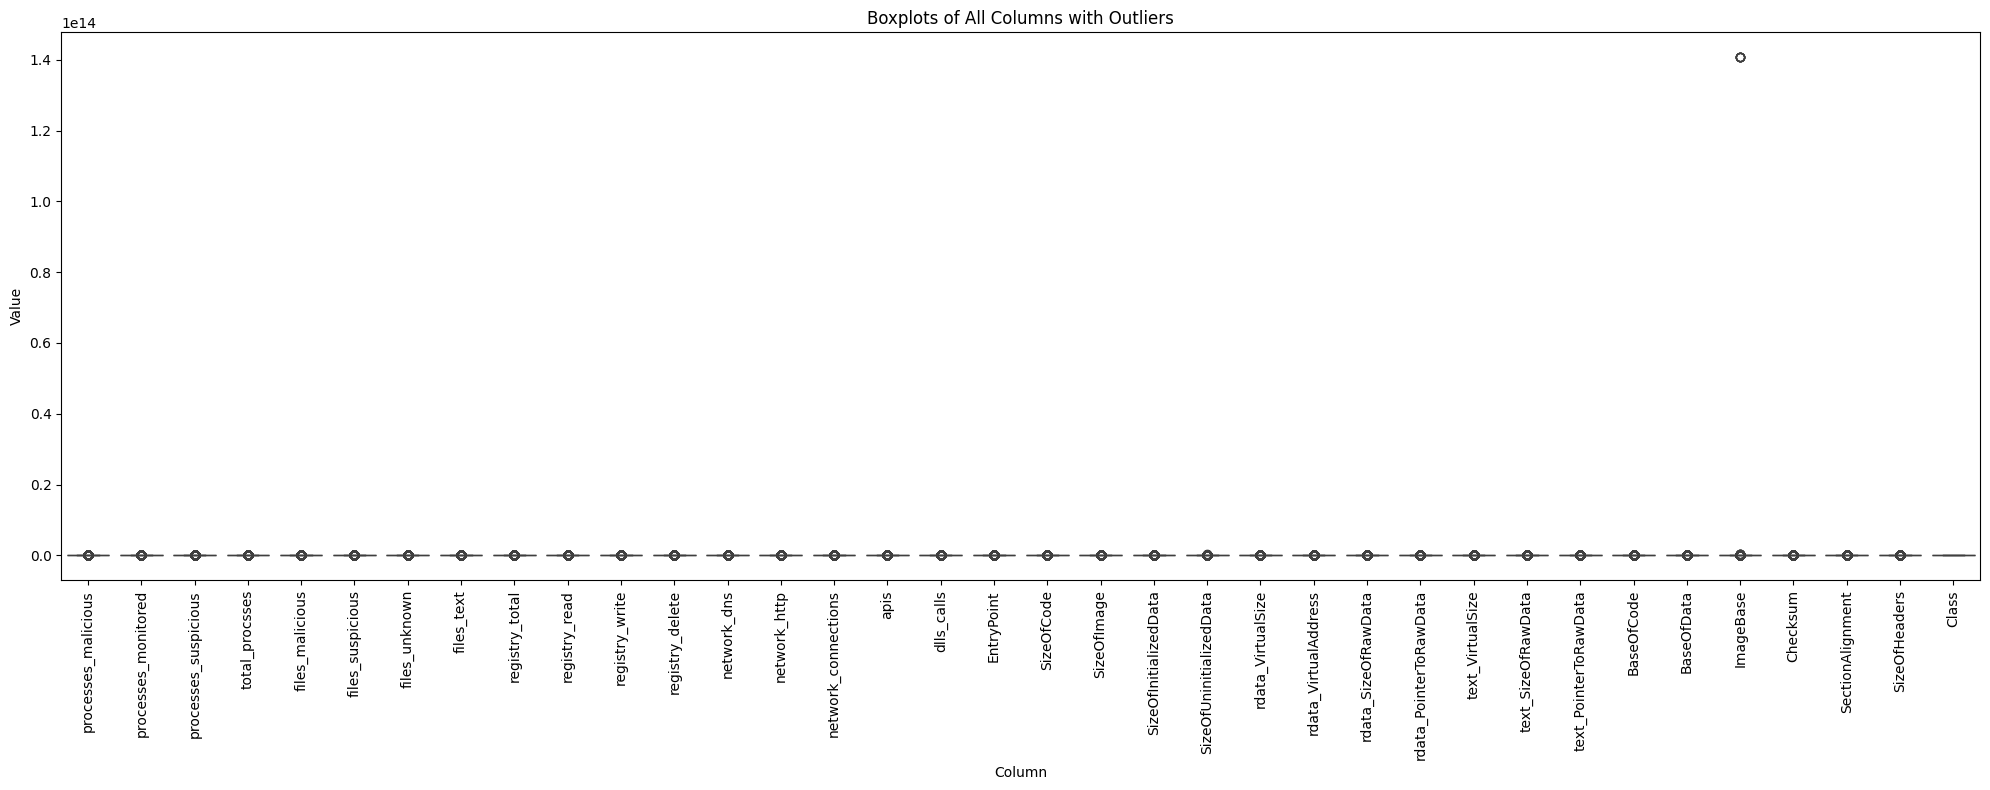

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


In [13]:
outliers_per_column = {}
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_per_column[col] = len(outliers)

In [14]:
outliers_per_column

{'processes_malicious': 1307,
 'processes_monitored': 2860,
 'processes_suspicious': 3061,
 'total_procsses': 3914,
 'files_malicious': 3633,
 'files_suspicious': 4614,
 'files_unknown': 4613,
 'files_text': 4157,
 'registry_total': 2935,
 'registry_read': 2919,
 'registry_write': 4460,
 'registry_delete': 2626,
 'network_dns': 3044,
 'network_http': 4231,
 'network_connections': 1537,
 'apis': 1587,
 'dlls_calls': 862,
 'EntryPoint': 2678,
 'SizeOfCode': 2503,
 'SizeOfImage': 3251,
 'SizeOfInitializedData': 3691,
 'SizeOfUninitializedData': 2114,
 'rdata_VirtualSize': 3650,
 'rdata_VirtualAddress': 3115,
 'rdata_SizeOfRawData': 3490,
 'rdata_PointerToRawData': 3039,
 'text_VirtualSize': 2467,
 'text_SizeOfRawData': 2701,
 'text_PointerToRawData': 10388,
 'BaseOfCode': 3034,
 'BaseOfData': 2757,
 'ImageBase': 4326,
 'Checksum': 3618,
 'SectionAlignment': 2084,
 'SizeOfHeaders': 8933,
 'Class': 0}

In [15]:
#Cap Outliers (Winsorize / Clipping Approach)
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                 np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to columns with outliers
for col, count in outliers_per_column.items():
    if count > 0:
        df = cap_outliers_iqr(df, col)

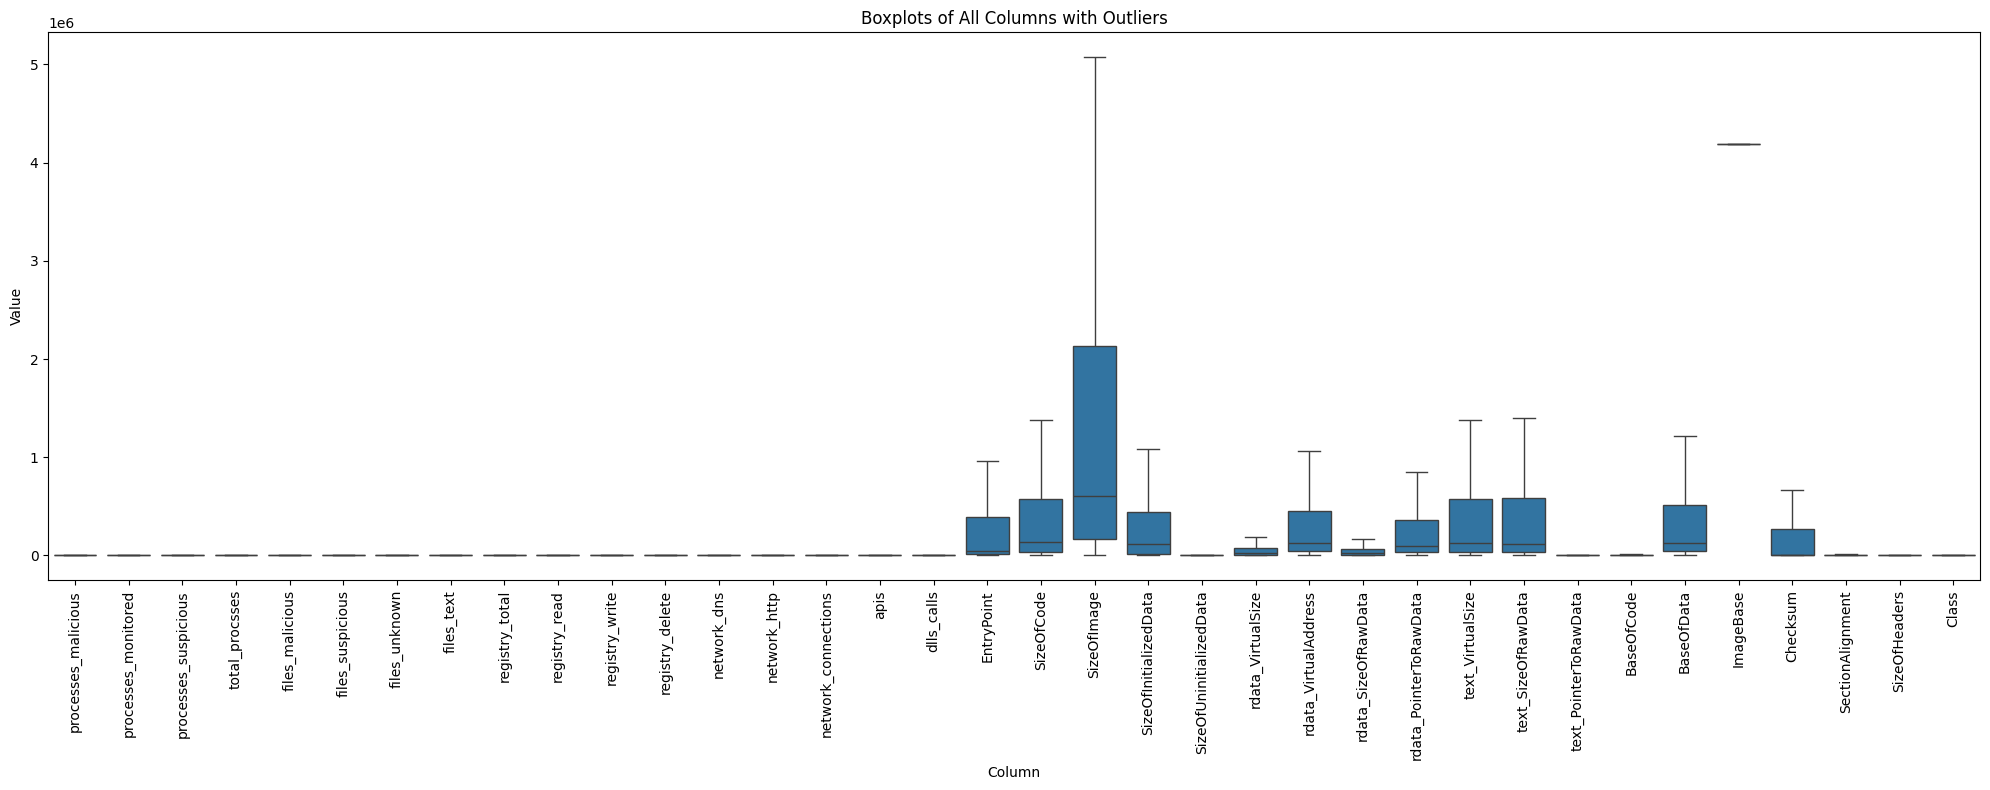

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


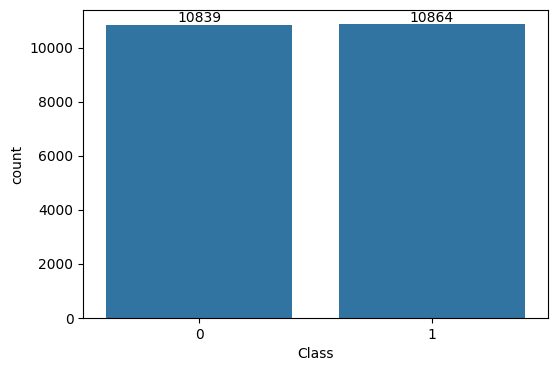

In [17]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Class',data=df)
for i in ax.containers:
    ax.bar_label(i,)

<h3>Normalization</h3>

In [18]:
from sklearn.preprocessing import StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = df.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [19]:
# Separate features and labels
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Class labels
X.shape

(21703, 35)

In [20]:
y.shape

(21703,)

<h3>CNN with 20 Epochs Implementation</h3>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 33, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,882 (323.76 KB)

 Trainable params: 82,882 (323.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8698 - loss: 0.3340 - val_accuracy: 0.9767 - val_loss: 0.0743
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9720 - loss: 0.0935 - val_accuracy: 0.9842 - val_loss: 0.0491
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9788 - loss: 0.0698 - val_accuracy: 0.9868 - val_loss: 0.0402
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9860 - loss: 0.0496 - val_accuracy: 0.9905 - val_loss: 0.0323
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9850 - loss: 0.0499 - val_accuracy: 0.9911 - val_loss: 0.0319
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9889 - loss: 0.0430 - val_accuracy: 0.9899 - val_loss: 0.0332
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9884 - loss: 0.0415 - val_accuracy: 0.9922 - val_loss: 0.0273
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9909 - loss: 0.0331 - val_accu

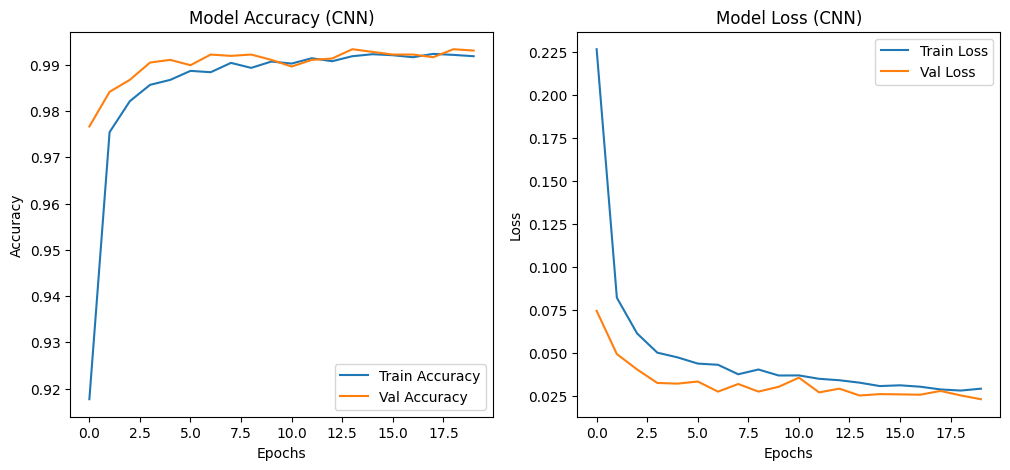

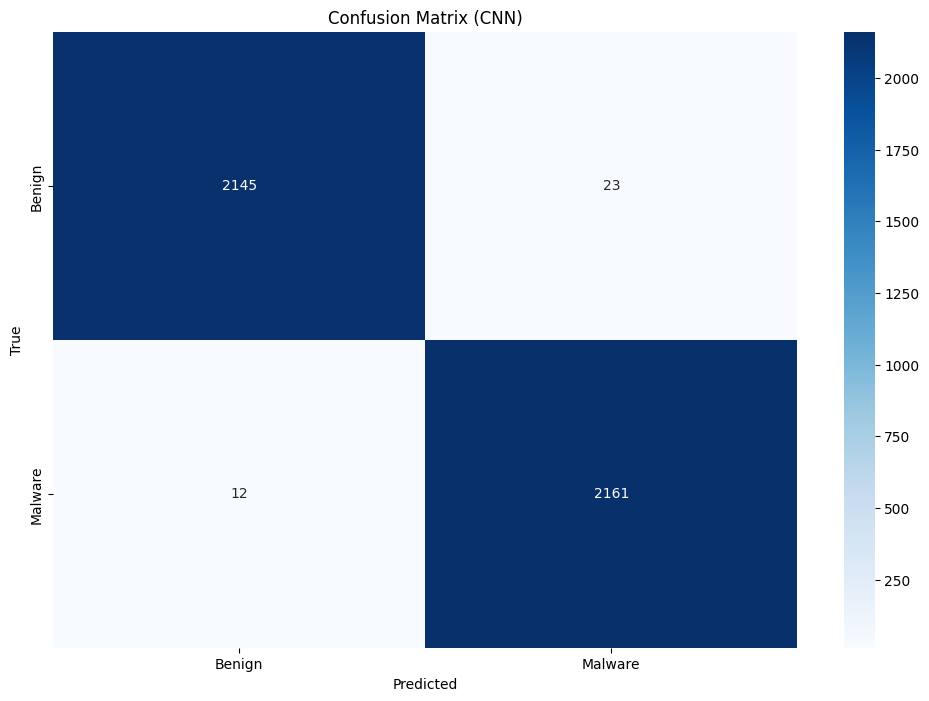

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# Reshape for CNN [samples, timesteps, features]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

n_classes = y_categorical.shape[1]
n_features = X_train.shape[1]

# =====================================
# CNN Model
# =====================================
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_features, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='sigmoid')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

# =====================================
# Train Model
# =====================================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# =====================================
# Evaluation
# =====================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred_classes)
prec = precision_score(y_true, y_pred_classes, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred_classes, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average="weighted", zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=encoder.classes_.astype(str)))

# =====================================
# Plot Accuracy & Loss
# =====================================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy (CNN)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/cnn-binary-accuracy.pdf")   # <-- save as PDF
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss (CNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/cnn-binary-loss.pdf")   # <-- save as PDF
plt.show()

# =====================================
# Confusion Matrix
# =====================================
# Confusion Matrix
class_names = ['Benign', 'Malware']

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/cnn-confusion.pdf")   # <-- save as PDF
plt.show()